# Time series forcasting on daily minimal temperatures

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as ks
import tensorflow as tf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


2023-06-23 09:02:35.887489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 09:02:36.315205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 09:02:36.319002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 09:02:37.846397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Analysing properties of data set

### Time series decompositon using STL

In [18]:
# Define function to process raw data for cleaned up data set
def tweak_date_temperature(df_):
    return (df_.assign(Date = lambda df: # date as datetime localized at Melbourne 
                       df.Date.astype('datetime64').dt.tz_localize('Australia/Melbourne')
                      )
            .set_index('Date') # Use date column as index
           )

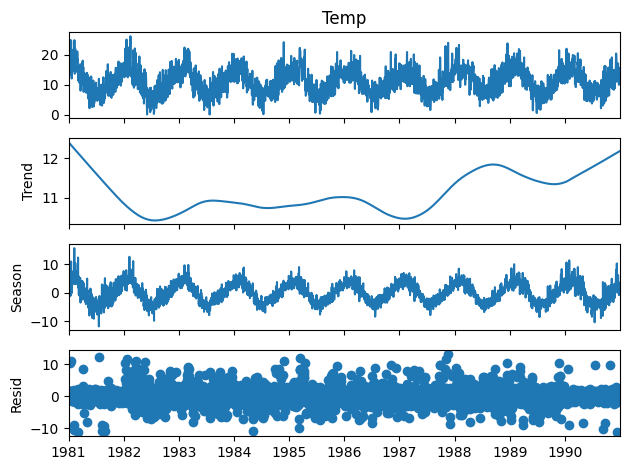

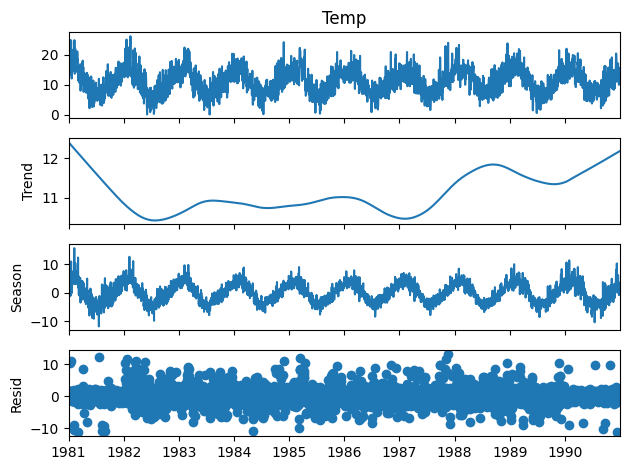

In [8]:
# Load data set and process it with function "tweak_date_temperature()"
data = tweak_date_temperature(pd.read_csv('daily-min-temperatures.csv'))

# Seperate components by STL decomposition
STL_result = STL(data.Temp, period=365, seasonal=7, robust=True).fit()
STL_result.plot()


In [9]:
# Judging, whether residuals of STL decomposition is normaly distributed with Shapiro-Wilk test
# Result: By any typical significance it can be excluded, that the residuals are normaly distributed 
test_stat, p_value = sc.stats.shapiro(STL_result.resid)
print(f"Result of Shapiro-Wilk-Test:\np-value: {p_value:.1E} (test statistics: {test_stat:.2f})", 
"\nThe null-hypotheses (Residuals are normaly distributed) can be rejected.")

Result of Shapiro-Wilk-Test:
p-value: 8.5E-40 (test statistics: 0.92) 
The null-hypotheses (Residuals are normaly distributed) can be rejected.


Text(0, 0.5, 'Autocorrelation')

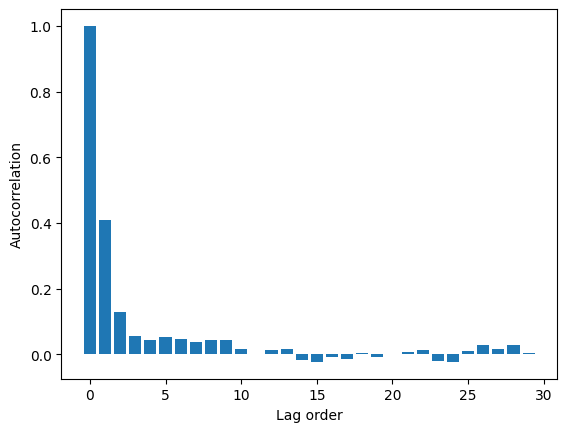

In [10]:
# Calculating and plotting autocorrelation of residuals
Resid_autocorr = pd.DataFrame([[i, STL_result.resid.autocorr(i)] for i in range(30)], 
                              columns=['Lag_order', 'Autocorrelation'])

plt.bar(Resid_autocorr['Lag_order'], Resid_autocorr['Autocorrelation'])
plt.xlabel('Lag order')
plt.ylabel('Autocorrelation')

### Box-Cox-Transformation on time series was evaluated, though results didn't went better. Nontheless it is shown here, that Box-Cox backtransformation succeeds, if time series was previously shifted to positive values by adding a constant

In [11]:
# Box-Cox-Transformation on Temperature Data (shift Temperature by constant to obtain positive numbers)
const = 10
BoxCox_result = sc.stats.boxcox(data.Temp + const)
# Construct DataFrame of result of Box-Cox-Transformation, using same index as time series
data_BoxCox_transformed = pd.DataFrame(BoxCox_result[0], index=data.index, columns=['BoxCox_transform'])
# Saving lambda parameter used for Box-Cox-Transformation
lam = BoxCox_result[1]
# Adding new column to DataFrame with back transformed Temperature values
data_BoxCox_transformed = data_BoxCox_transformed.assign(
    Temp_backtransform=lambda df_: (df_.BoxCox_transform*lam + 1)**(1/lam) - const)
#Checking, if backtransformation of Box-Cox-transformation succeeds. It does with sufficient accuracy.
data[(data.Temp - data_BoxCox_transformed.Temp_backtransform) > 1E-6].empty

True

### Applying ADF ttest on residuals to check for stationarity

APF 
Null-hypothesis: Residuals are non-stationary or there is a unit root 

In [14]:
ADF_crit_value, ADF_p_value, _, _, crit_value_dict, _ = adfuller(STL_result.resid.values, maxlag=30, #choosing maxlag from observed decline of autocorrelation
         regression='n') # 'n' for no constant or linear trend to include
print('Results of ADF-Test\np-value = ', ADF_p_value, '\nCritical values for test statistics are:')
for i, item in enumerate(crit_value_dict.items()):
    print('Critical value for '+item[0], ' ' * (12 - len(item[0])), ':', item[1])
print('Observerd test statistic value is:', ADF_crit_value)
print('\nNull-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.')

Results of ADF-Test
p-value =  0.0 
Critical values for test statistics are:
Critical value for 1%            : -2.5663536611966333
Critical value for 5%            : -1.941073942615193
Critical value for 10%           : -1.616747336810026
Observerd test statistic value is: -22.890554475554488

Null-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.


## Create function to create time shift series and load data

In [16]:

def time_series_to_supervised_learning(df_, n_shift_back=None, n_shift_forward=None, dropna=True):
    '''Function is designed to create new columns of all existing columns of df_. df_is seen as a time series.
    Thus, it is recommended to store all time information in index.
    df_ is time series pandas.Series or pandas.DataFrame
    n_shift_back is integer of how often index should be shiftet backwards. Creating new columns each shift.
    n_shift_forward is integer of how often index should be shiftet forwards. Creating new columns each shift.'''
    # Storing all column labels of initial DataFrame
    cols = df_.columns.values
    # Step through all backward time steps, when some were given
    if n_shift_back != None:
        for i in range(1, n_shift_back + 1):
            # dictionary to store new columns assignments in
            shift_dict = {}
            # step through all columns of initial DataFrame
            for _, col in enumerate(cols):
                # construct name of new (shiftet in time) column
                col_name = col + '(t' + str(-i) + ')'
                # store command to shift column in dictionary and use constructed column name as key
                shift_dict.update({col_name: df_[col].shift(i)})
            df_ = df_.assign(**shift_dict)
            # read colum names, so they can be ordered afterwards
            temporary_cols = list(df_.columns)
            # slice of the new columns assigned to the right of df_ and sort them before all other columns
            new_cols = temporary_cols[-len(cols):] + temporary_cols[:-len(cols)]
            # Reorder columns to new order
            df_ = df_[new_cols]
    if n_shift_forward != None:
        for i in range(1, n_shift_forward+1):
            # dictionary to store new columns assignments in
            shift_dict = {}
            # step through all columns of initial DataFrame
            for _, col in enumerate(cols):
                # construct name of new (shifted in time) column
                col_name = col + '(t+' + str(i) + ')'
                # store command to shift column in dictionary and use constructed column name as key
                shift_dict.update({col_name: df_[col].shift(-i)})
            df_ = df_.assign(**shift_dict)
    # Drop rows with NA, if defined by dropna and return DataFrame                
    if dropna:
        return df_.dropna()
    else:
        return df_

In [24]:
# Load dataset in a pandas DataFrame
df_raw = pd.read_csv('daily-min-temperatures.csv')
# Clean up with tweak-function
df_clean = tweak_date_temperature(df_raw)
# Define number of timesteps
n_timesteps = 2
# Use tweak function to set index to local Melbourne time and add shifted column (y) for supervised learning
df = time_series_to_supervised_learning(df_clean, n_shift_back=n_timesteps)

In [26]:
# Scaling
df = df.assign(**{(col + '_scaled'): (df[col] - df[col].min())/
                  (df[col].max() - df[col].min()) for col in df.columns
               }
              )

#df = df.assign(**{(col + '_scaled'): (df[col] - df[col].min())/(df[col].max() - df[col].min()) for col in df.columns

# Split off two datasets to be used as training and evaluation datasets
df_train = df.loc[:'1987-07-29']
df_eval = df.loc['1987-07-30':]


# Create numpy arrays of shape (samples, timesteps, features), where timesteps=1, features=1
# Use unshifted Temperature column as target_values for training, thus predictions won't need to 
# shift in order to allign with 
y_target = df_train['Temp_scaled'].to_numpy().astype(np.float32)[:, np.newaxis, np.newaxis]
x_train = df_train.loc[:, f'Temp(t-{n_timesteps})_scaled':'Temp(t-1)_scaled'].to_numpy().astype(np.float32)[:, :, np.newaxis]
# Similar for evaluation data set, only x-values needed
x_eval = df.loc[:, f'Temp(t-{n_timesteps})_scaled':'Temp(t-1)_scaled'].to_numpy().astype(np.float32)[:, :, np.newaxis]

## Define model and train it

In [27]:
RNN = ks.Sequential()
RNN.add(ks.layers.LSTM(100, input_shape=(n_timesteps, 1), return_sequences=False)) #hidden layer
RNN.add(ks.layers.Dense(1, activation='linear')) # output layer

RNN.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer='adam') 

# List to add up values of loss function during training
history_buffer_loss = []

2023-06-23 09:15:48.885843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 09:15:48.888410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 09:15:48.889771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2023-06-23 09:15:54.829400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 09:15:54.832174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 09:15:54.834287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

75/75 [==============================] - 2s 4ms/step - loss: 0.0447 - mean_squared_error: 0.0447
Epoch 2/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 3/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 4/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 5/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 6/30
75/75 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 7/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 8/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 9/30
75/75 [==============================] - 0s 4ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 10/30
75/75 [====================

Text(0.5, 0.98, 'Loss function')

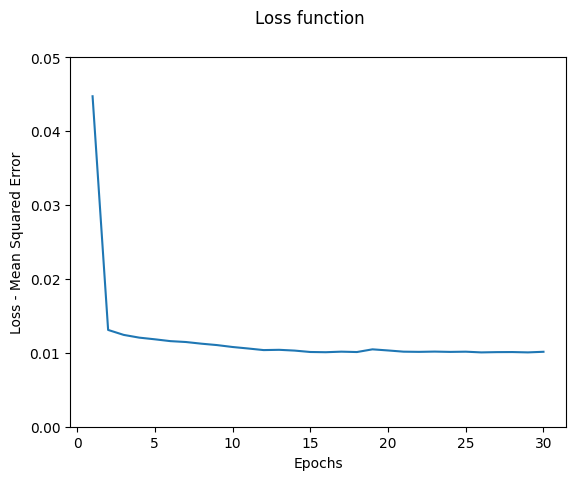

In [28]:
# Fit model on training data
history = RNN.fit(x_train, y_target, batch_size=32, epochs=30)
# Adding up information about loss for each epoch
history_buffer_loss += history.history['loss']

# plotting loss function
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=0.05) #top=np.max(history_buffer_loss).round(1) + 0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss - Mean Squared Error')
ax.plot(list(range(1, len(history_buffer_loss) + 1)), history_buffer_loss)
fig.suptitle('Loss function')

In [29]:
# Predict on evaluation data set
y_eval_predict = pd.Series(RNN.predict(x_eval)[:, 0].flatten(), index=df.index)
# Back scaling of predicted data
y_eval_predict = (y_eval_predict*(df.Temp.max() - df.Temp.min())) + df.Temp.min()

df = df.assign(Temp_predict=y_eval_predict).fillna(0.0)

  1/114 [..............................] - ETA: 53s

2023-06-23 09:16:11.804202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 09:16:11.806776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 09:16:11.810218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

114/114 [==============================] - 1s 2ms/step


In [30]:
df

,Temp(t-2),Temp(t-1),Temp,Temp(t-2)_scaled,Temp(t-1)_scaled,Temp_scaled,Temp_predict
Date,,,,,,,
1981-01-03 00:00:00+11:00,20.7,17.9,18.8,0.787072,0.680608,0.714829,17.026785
1981-01-04 00:00:00+11:00,17.9,18.8,14.6,0.680608,0.714829,0.555133,17.542801
1981-01-05 00:00:00+11:00,18.8,14.6,15.8,0.714829,0.555133,0.600760,14.419138
1981-01-06 00:00:00+11:00,14.6,15.8,15.8,0.555133,0.600760,0.600760,15.011344
1981-01-07 00:00:00+11:00,15.8,15.8,15.8,0.600760,0.600760,0.600760,15.117405
...,...,...,...,...,...,...,...
1990-12-27 00:00:00+11:00,12.9,14.6,14.0,0.490494,0.555133,0.532319,13.971246
1990-12-28 00:00:00+11:00,14.6,14.0,13.6,0.555133,0.532319,0.517110,13.697291
1990-12-29 00:00:00+11:00,14.0,13.6,13.5,0.532319,0.517110,0.513308,13.356075


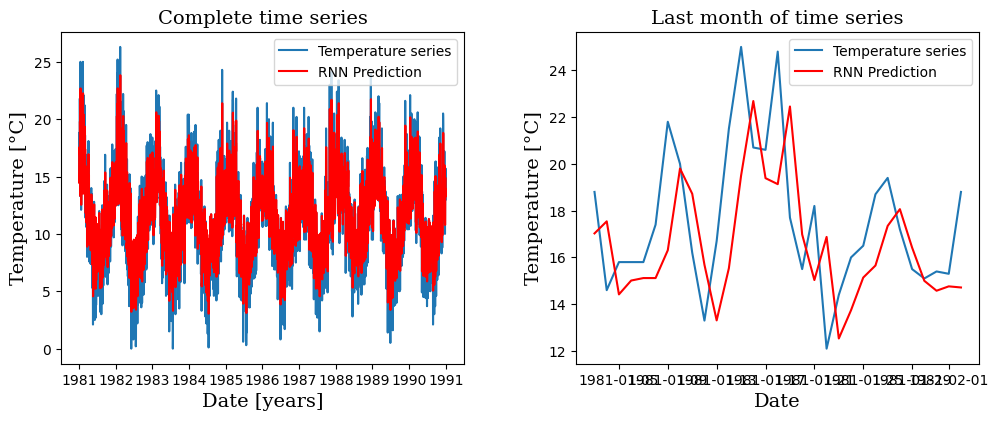

In [72]:
# defining font for labels and titles
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df.Temp, label='Temperature series')
axes[0].plot(df.Temp_predict, color='red', label='RNN Prediction')
axes[0].set_xlabel('Date [years]', fontdict=font)
axes[0].set_ylabel('Temperature [°C]', fontdict=font)
axes[0].set_title('Complete time series', fontdict=font)
axes[0].legend()
axes[1].plot(df.Temp[:31], label='Temperature series')
axes[1].plot(df.Temp_predict[:31], color='red', label='RNN Prediction')
axes[1].set_xlabel('Date', fontdict=font)
axes[1].set_ylabel('Temperature [°C]', fontdict=font)
axes[1].set_title('Last month of time series', fontdict=font)
axes[1].legend()

The results are not satisfying. The networks gets the seasonal trend, but fails to predict short time temperatures. On short time the network's forecast resemble a naive forecast.